In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('..')
import optimizer
import warnings
import os
from optimizer import Adam, AdamWithDiff, AdaGradWithDiff, AdaGrad
warnings.filterwarnings('ignore')

In [ ]:
# Function to load CIFAR10 dataset
def load_data(batch_size):
    transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.RandomCrop(32, padding=4),
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

    trainset = torchvision.datasets.CIFAR10(root='./src/data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=4)

    testset = torchvision.datasets.CIFAR10(root='./src/data', train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=4)
    
    print("Number of training examples: ", len(trainset))
    print("Number of test examples: ", len(testset))
    return trainloader, testloader

# Function to train the model
def train_model(model, trainloader, criterion, optimizer, device, num_epochs, testloader):
    model.train()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100.0 * correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

        model.eval()
        val_loss, val_acc = validate_model(model, testloader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

    return train_losses, train_accuracies, val_losses, val_accuracies

# Function to validate the model
def validate_model(model, testloader, criterion, device):
    model.eval()
    validation_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = validation_loss / len(testloader)
    val_acc = 100.0 * correct / total

    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')
    return val_loss, val_acc

# Function to plot loss and accuracy
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, plot_name = None):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.show()

def df_model(with_batch_norm, device):
    if with_batch_norm:
        model = models.resnet34(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 10)
        model = model.to(device)
        return model
    else:
        model = models.resnet34(weights=None)
        model = remove_batch_norm_layers(model)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 10)
        model = model.to(device)
        return model # Implement the model without batch normalization

def remove_batch_norm_layers(model):
    for name, module in model.named_children():
        if isinstance(module, nn.BatchNorm2d):
            setattr(model, name, nn.Identity())
        else:
            remove_batch_norm_layers(module)
    return model


# Main function to run the training and validation
def main(model, optimizer, batch_size, num_epochs, experiment_name, save_path, plot = False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    trainloader, testloader = load_data(batch_size)

    criterion = nn.CrossEntropyLoss()
    

    train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, trainloader, criterion, optimizer, device, num_epochs, testloader)

    # save the train-val loss and accuracy
    os.makedirs(save_path, exist_ok=True)
    np.save(save_path + experiment_name + '_train_losses.npy', train_losses)
    np.save(save_path + experiment_name + '_train_accuracies.npy', train_accuracies)
    np.save(save_path + experiment_name + '_val_losses.npy', val_losses)
    np.save(save_path + experiment_name + '_val_accuracies.npy', val_accuracies)


    if plot:
        plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, experiment_name)

    return train_losses, train_accuracies, val_losses, val_accuracies

if __name__ == '__main__':

    #adam with batch norm
    model = df_model(with_batch_norm=False, device=torch.device("cuda"))
    opt = Adam(model.parameters())
    train_losses, train_accuracies, val_losses, val_accuracies = main(model,optimizer= opt, batch_size=256, num_epochs=100, experiment_name='resnet34_with_ADAM_custom_with_batch_norm', save_path='./results/')

    #adam without batch norm
    model = df_model(with_batch_norm=True, device=torch.device("cuda"))
    opt = Adam(model.parameters())
    train_losses, train_accuracies, val_losses, val_accuracies = main(model,optimizer= opt, batch_size=256, num_epochs=100, experiment_name='resnet34_with_ADAM_custom_without_batch_norm', save_path='./results/')

    #adagrad with batch norm
    model = df_model(with_batch_norm=False, device=torch.device("cuda"))
    opt = AdaGrad(model.parameters())
    train_losses, train_accuracies, val_losses, val_accuracies = main(model,optimizer= opt, batch_size=256, num_epochs=100, experiment_name='resnet34_with_AdaGrad_custom_with_batch_norm', save_path='./results/')

    #adagrad without batch norm
    model = df_model(with_batch_norm=True, device=torch.device("cuda"))
    opt = AdaGrad(model.parameters())
    train_losses, train_accuracies, val_losses, val_accuracies = main(model,optimizer= opt, batch_size=256, num_epochs=100, experiment_name='resnet34_with_AdaGrad_custom_without_batch_norm', save_path='./results/')

    #AdamWithDiff with batch norm
    model = df_model(with_batch_norm=True, device=torch.device("cuda"))
    opt = AdamWithDiff(model.parameters())
    train_losses, train_accuracies, val_losses, val_accuracies = main(model,optimizer= opt, batch_size=256, num_epochs=100, experiment_name='resnet34_with_ADAMwithdiff_with_batch_norm', save_path='./results/')

    #AdamWithDiff without batch norm
    model = df_model(with_batch_norm=False, device=torch.device("cuda"))
    opt = AdamWithDiff(model.parameters())
    train_losses, train_accuracies, val_losses, val_accuracies = main(model,optimizer= opt, batch_size=256, num_epochs=100, experiment_name='resnet34_with_ADAMwithdiff_without_batch_norm', save_path='./results/')

    #AdaGradWithDiff with batch norm
    model = df_model(with_batch_norm=True, device=torch.device("cuda"))
    opt = AdaGradWithDiff(model.parameters())
    train_losses, train_accuracies, val_losses, val_accuracies = main(model,optimizer= opt, batch_size=256, num_epochs=100, experiment_name='resnet34_with_AdaGradWithDiff_with_batch_norm', save_path='./results/')

    #AdaGradWithDiff without batch norm
    model = df_model(with_batch_norm=False, device=torch.device("cuda"))
    opt = AdaGradWithDiff(model.parameters())
    train_losses, train_accuracies, val_losses, val_accuracies = main(model,optimizer= opt, batch_size=256, num_epochs=100, experiment_name='resnet34_with_AdaGradWithDiff_without_batch_norm', save_path='./results/')

    

### Ploting the result

In [4]:
COLOR_adadiff = 'orange'
COLOR_adam = 'blue'
COLOR_ada = 'red'
COLOR_adamdiff = 'magenta'

#### Training loss

In [31]:
train_loss_adam_w_bn = np.load("./results/resnet34_with_ADAM_custom_with_batch_norm_train_losses.npy")
train_loss_adam_wo_bn = np.load("./results/resnet34_with_ADAM_custom_without_batch_norm_train_losses.npy")
train_loss_ada_w_bn = np.load("./results/resnet34_with_AdaGrad_custom_with_batch_norm_train_losses.npy")
train_loss_ada_wo_bn = np.load("./results/resnet34_with_AdaGrad_custom_without_batch_norm_train_losses.npy")

train_loss_adagrad_w_diff_w_bn = np.load("./results/resnet34_with_AdaGradWithDiff_with_batch_norm_train_losses.npy")
train_loss_adagrad_w_diff_wo_bn = np.load("./results/resnet34_with_AdaGradWithDiff_without_batch_norm_train_losses.npy")
train_loss_adam_w_diff_w_bn = np.load("./results/resnet34_with_ADAMwithdiff_with_batch_norm_train_losses.npy")
train_loss_adam_w_diff_wo_bn = np.load("./results/resnet34_with_ADAMwithdiff_without_batch_norm_train_losses.npy")

In [35]:
#small hack for big values
train_loss_ada_w_bn[0] = train_loss_ada_w_bn[1]
train_loss_adagrad_w_diff_wo_bn[0] = train_loss_adagrad_w_diff_wo_bn[1]

Text(0.5, 1.0, 'Training Loss')

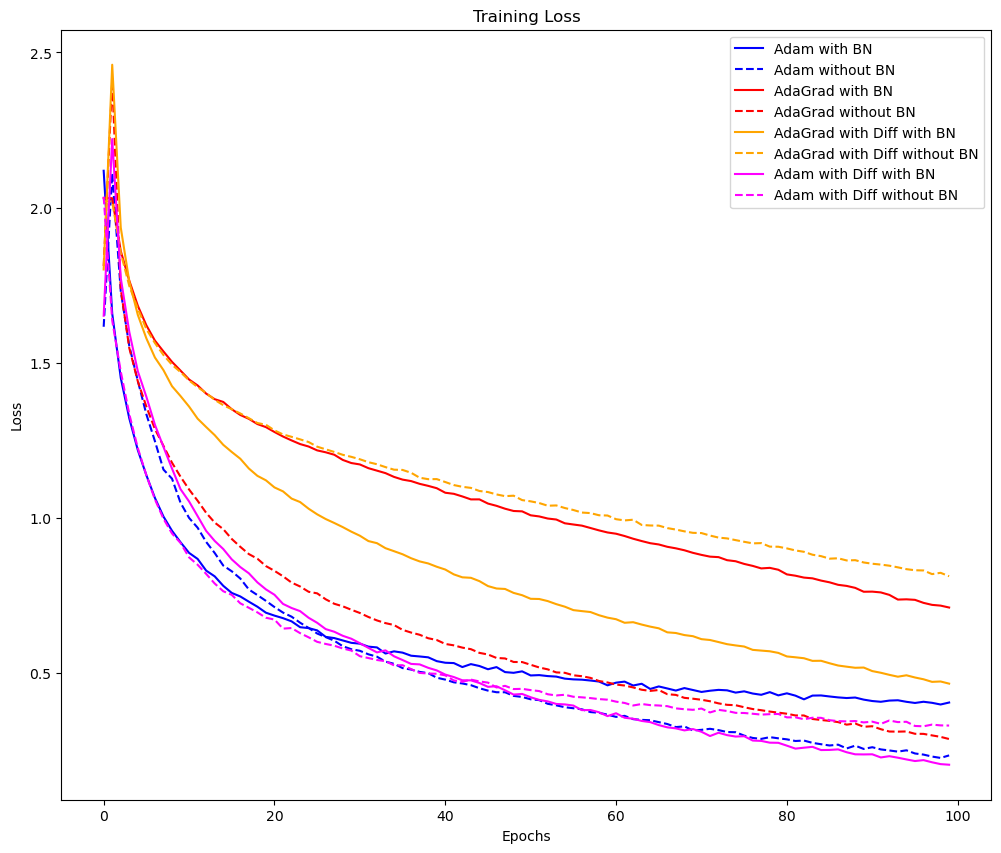

In [37]:
plt.figure(figsize=(12, 10))

plt.plot(train_loss_adam_w_bn, label='Adam with BN', color=COLOR_adam)
plt.plot(train_loss_adam_wo_bn, label='Adam without BN', color=COLOR_adam, linestyle='dashed')

plt.plot(train_loss_ada_w_bn, label='AdaGrad with BN', color=COLOR_ada)
plt.plot(train_loss_ada_wo_bn, label='AdaGrad without BN', color=COLOR_ada, linestyle='dashed')


plt.plot(train_loss_adagrad_w_diff_w_bn, label='AdaGrad with Diff with BN', color=COLOR_adadiff)
plt.plot(train_loss_adagrad_w_diff_wo_bn, label='AdaGrad with Diff without BN', color=COLOR_adadiff, linestyle='dashed')

plt.plot(train_loss_adam_w_diff_w_bn, label='Adam with Diff with BN', color=COLOR_adamdiff)
plt.plot(train_loss_adam_w_diff_wo_bn, label='Adam with Diff without BN', color=COLOR_adamdiff, linestyle='dashed')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

#### Training accuracies


In [39]:
#Training accuracies

train_acc_adam_w_bn = np.load("./results/resnet34_with_ADAM_custom_with_batch_norm_train_accuracies.npy")
train_acc_adam_wo_bn = np.load("./results/resnet34_with_ADAM_custom_without_batch_norm_train_accuracies.npy")
train_acc_ada_w_bn = np.load("./results/resnet34_with_AdaGrad_custom_with_batch_norm_train_accuracies.npy")
train_acc_ada_wo_bn = np.load("./results/resnet34_with_AdaGrad_custom_without_batch_norm_train_accuracies.npy")

train_acc_adagrad_w_diff_w_bn = np.load("./results/resnet34_with_AdaGradWithDiff_with_batch_norm_train_accuracies.npy")
train_acc_adagrad_w_diff_wo_bn = np.load("./results/resnet34_with_AdaGradWithDiff_without_batch_norm_train_accuracies.npy")
train_acc_adam_w_diff_w_bn = np.load("./results/resnet34_with_ADAMwithdiff_with_batch_norm_train_accuracies.npy")
train_acc_adam_w_diff_wo_bn = np.load("./results/resnet34_with_ADAMwithdiff_without_batch_norm_train_accuracies.npy")


Text(0.5, 1.0, 'Training Accuracy')

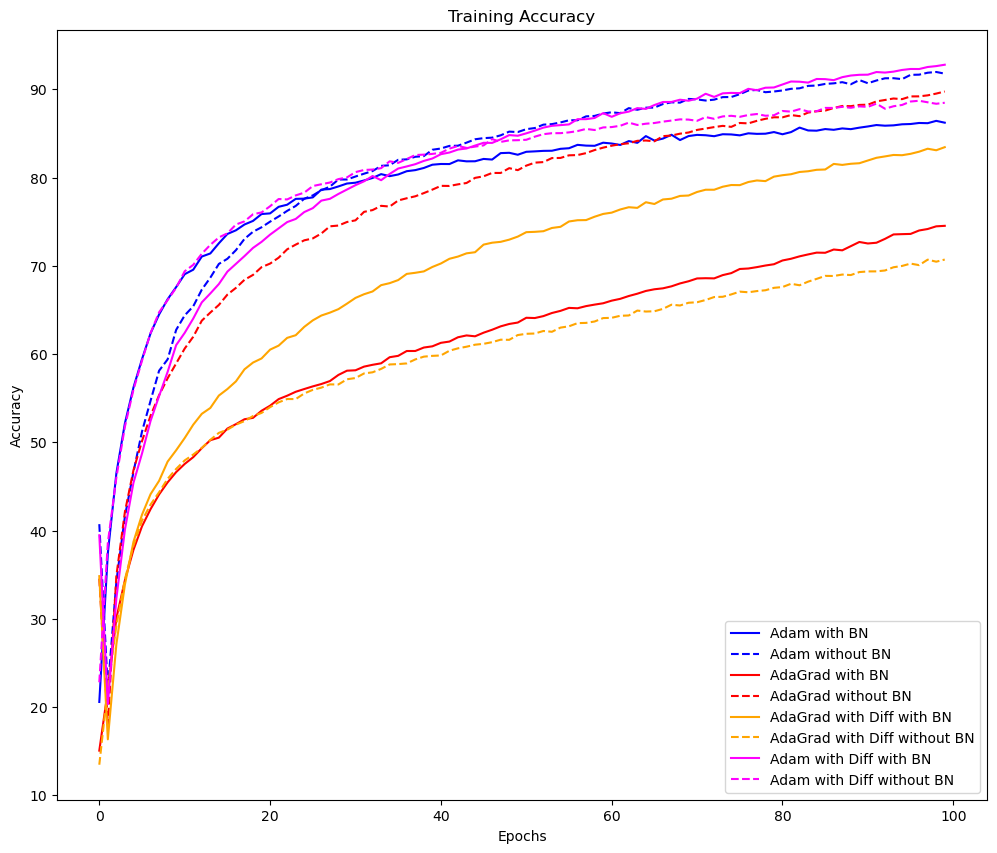

In [40]:
plt.figure(figsize=(12, 10))

plt.plot(train_acc_adam_w_bn, label='Adam with BN', color=COLOR_adam)
plt.plot(train_acc_adam_wo_bn, label='Adam without BN', color=COLOR_adam, linestyle='dashed')

plt.plot(train_acc_ada_w_bn, label='AdaGrad with BN', color=COLOR_ada)
plt.plot(train_acc_ada_wo_bn, label='AdaGrad without BN', color=COLOR_ada, linestyle='dashed')

plt.plot(train_acc_adagrad_w_diff_w_bn, label='AdaGrad with Diff with BN', color=COLOR_adadiff)
plt.plot(train_acc_adagrad_w_diff_wo_bn, label='AdaGrad with Diff without BN', color=COLOR_adadiff, linestyle='dashed')

plt.plot(train_acc_adam_w_diff_w_bn, label='Adam with Diff with BN', color=COLOR_adamdiff)
plt.plot(train_acc_adam_w_diff_wo_bn, label='Adam with Diff without BN', color=COLOR_adamdiff, linestyle='dashed')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy')

#### Validation loss

In [42]:
#Validation Losses
val_loss_adam_w_bn = np.load("./results/resnet34_with_ADAM_custom_with_batch_norm_val_losses.npy")
val_loss_adam_wo_bn = np.load("./results/resnet34_with_ADAM_custom_without_batch_norm_val_losses.npy")
val_loss_ada_w_bn = np.load("./results/resnet34_with_AdaGrad_custom_with_batch_norm_val_losses.npy")
val_loss_ada_wo_bn = np.load("./results/resnet34_with_AdaGrad_custom_without_batch_norm_val_losses.npy")

val_loss_adagrad_w_diff_w_bn = np.load("./results/resnet34_with_AdaGradWithDiff_with_batch_norm_val_losses.npy")
val_loss_adagrad_w_diff_wo_bn = np.load("./results/resnet34_with_AdaGradWithDiff_without_batch_norm_val_losses.npy")
val_loss_adam_w_diff_w_bn = np.load("./results/resnet34_with_ADAMwithdiff_with_batch_norm_val_losses.npy")
val_loss_adam_w_diff_wo_bn = np.load("./results/resnet34_with_ADAMwithdiff_without_batch_norm_val_losses.npy")

Text(0.5, 1.0, 'Validation Loss')

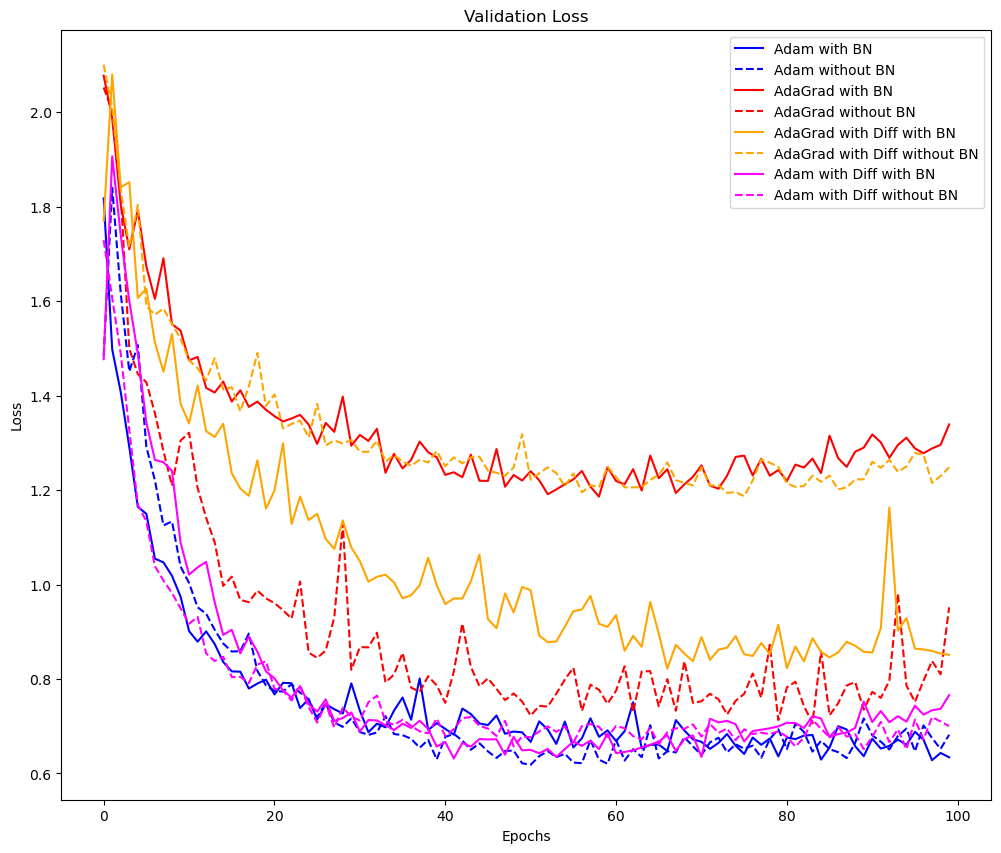

In [43]:
plt.figure(figsize=(12, 10))
plt.plot(val_loss_adam_w_bn, label='Adam with BN', color=COLOR_adam)
plt.plot(val_loss_adam_wo_bn, label='Adam without BN', color=COLOR_adam, linestyle='dashed')

plt.plot(val_loss_ada_w_bn, label='AdaGrad with BN', color=COLOR_ada)
plt.plot(val_loss_ada_wo_bn, label='AdaGrad without BN', color=COLOR_ada, linestyle='dashed')

plt.plot(val_loss_adagrad_w_diff_w_bn, label='AdaGrad with Diff with BN', color=COLOR_adadiff)
plt.plot(val_loss_adagrad_w_diff_wo_bn, label='AdaGrad with Diff without BN', color=COLOR_adadiff, linestyle='dashed')

plt.plot(val_loss_adam_w_diff_w_bn, label='Adam with Diff with BN', color=COLOR_adamdiff)
plt.plot(val_loss_adam_w_diff_wo_bn, label='Adam with Diff without BN', color=COLOR_adamdiff, linestyle='dashed')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss')

#### Validation Accuracies

In [44]:
#validation accuracies
val_acc_adam_w_bn = np.load("./results/resnet34_with_ADAM_custom_with_batch_norm_val_accuracies.npy")
val_acc_adam_wo_bn = np.load("./results/resnet34_with_ADAM_custom_without_batch_norm_val_accuracies.npy")
val_acc_ada_w_bn = np.load("./results/resnet34_with_AdaGrad_custom_with_batch_norm_val_accuracies.npy")
val_acc_ada_wo_bn = np.load("./results/resnet34_with_AdaGrad_custom_without_batch_norm_val_accuracies.npy")

val_acc_adagrad_w_diff_w_bn = np.load("./results/resnet34_with_AdaGradWithDiff_with_batch_norm_val_accuracies.npy")
val_acc_adagrad_w_diff_wo_bn = np.load("./results/resnet34_with_AdaGradWithDiff_without_batch_norm_val_accuracies.npy")
val_acc_adam_w_diff_w_bn = np.load("./results/resnet34_with_ADAMwithdiff_with_batch_norm_val_accuracies.npy")
val_acc_adam_w_diff_wo_bn = np.load("./results/resnet34_with_ADAMwithdiff_without_batch_norm_val_accuracies.npy")


Text(0.5, 1.0, 'Validation Accuracy')

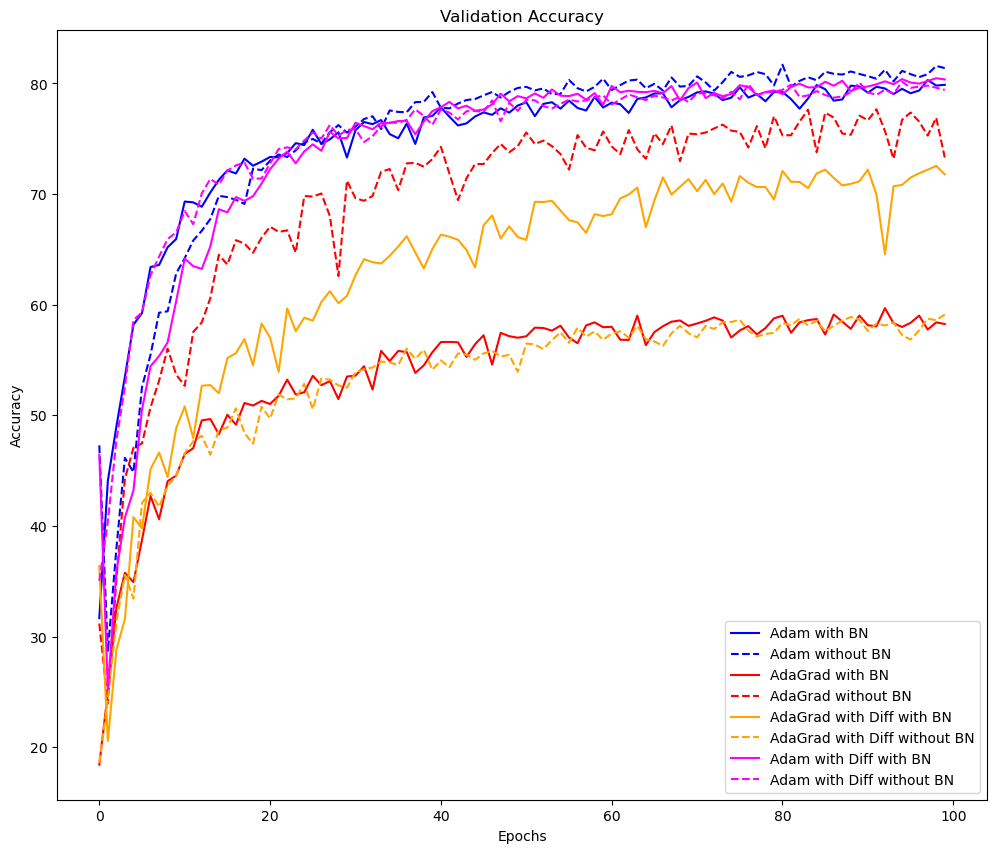

In [45]:
plt.figure(figsize=(12, 10))
plt.plot(val_acc_adam_w_bn, label='Adam with BN', color=COLOR_adam)
plt.plot(val_acc_adam_wo_bn, label='Adam without BN', color=COLOR_adam, linestyle='dashed')

plt.plot(val_acc_ada_w_bn, label='AdaGrad with BN', color=COLOR_ada)
plt.plot(val_acc_ada_wo_bn, label='AdaGrad without BN', color=COLOR_ada, linestyle='dashed')

plt.plot(val_acc_adagrad_w_diff_w_bn, label='AdaGrad with Diff with BN', color=COLOR_adadiff)
plt.plot(val_acc_adagrad_w_diff_wo_bn, label='AdaGrad with Diff without BN', color=COLOR_adadiff, linestyle='dashed')

plt.plot(val_acc_adam_w_diff_w_bn, label='Adam with Diff with BN', color=COLOR_adamdiff)
plt.plot(val_acc_adam_w_diff_wo_bn, label='Adam with Diff without BN', color=COLOR_adamdiff, linestyle='dashed')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')